The objective of this notebook is to carry out the experiments proposed in the article `"Analysis of Pipelining in Community Detection and Recommender Systems"`. The article explores the effectiveness of pipelining techniques in improving the performance of recommender systems by utilizing community detectors. 
This notebook serves as a comprehensive guide to replicate and analyze the experiments conducted in the article.

### Environment settings

In [1]:
"""
    Importing needed libs
"""

'\n    Importing needed libs\n'

In [2]:
import os
import time
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt

from surprise import (
    accuracy,
    Reader,
    Dataset,
    CoClustering,
    KNNBasic,
    NMF,
    SVD,
    SlopeOne,
    NormalPredictor
)
from surprise.model_selection.split import ShuffleSplit
from surprise.trainset import Trainset

import networkx as nx
import cdlib.algorithms as cd_alg
import karateclub as kc
from tqdm.notebook import tqdm


Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'wurlitzer'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer'}


In [3]:
"""
    Setting up functions
"""

'\n    Setting up functions\n'

In [4]:
def communitarian_recommendation_graph(
        n_user=100,
        n_comm=10,
        n_item=100,
        n_cat=10,
        like_prob=.4,
        like_strength=.5,
        debug=False,
    ):

    user_comm_gt = np.random.choice(n_comm, n_user)
    user_comm_gt.sort()
    bincount_user = np.bincount(user_comm_gt, minlength=n_comm)

    if debug:
        display('user', user_comm_gt, bincount_user)

    item_cat_gt = np.random.choice(n_cat, n_item)
    item_cat_gt.sort()
    bincount_item = np.bincount(item_cat_gt, minlength=n_cat)

    if debug:
        display('item', item_cat_gt, bincount_item)

    L = np.random.choice(2, (n_comm, n_cat), p=[1-like_prob, like_prob])

    L_prime = like_strength * L + (1-like_strength)/2

    P = np.block([
        [ np.zeros((n_comm,n_comm)) , L_prime                 ],
        [ L_prime.T                 , np.zeros((n_cat,n_cat)) ]
    ])

    if debug:
        display('like', L, L_prime, P)

    sbg = nx.stochastic_block_model(
        np.hstack((bincount_user, bincount_item)),
        P
    )

    if debug:
        try:
            nx.draw_networkx(
                sbg,
                nx.bipartite_layout(sbg, nx.bipartite.sets(sbg)[0]),
                node_color=np.hstack((user_comm_gt, item_cat_gt))
            )
        except nx.AmbiguousSolution as e:
            print(e)            

        plt.show()

    for user, item, data in sbg.edges(data=True):
        data['weight'] = np.random.randint(1,4) + 2*L[user_comm_gt[user], item_cat_gt[item-n_user]]

    if debug:
        display(np.mean([w['weight'] for user, item, w in sbg.edges(data=True) if L[user_comm_gt[min(user, item)], item_cat_gt[max(user, item)-n_user]]]))
        display(np.mean([w['weight'] for user, item, w in sbg.edges(data=True) if not L[user_comm_gt[min(user, item)], item_cat_gt[max(user, item)-n_user]]]))
        
    return sbg, user_comm_gt, item_cat_gt


def from_ratings_to_edges(ratings):
    edges = pd.DataFrame(ratings)[[0,1,2]]
    edges[[0,1]] = edges[[0,1]].astype(int)
    edges[[0,1]] -= edges[[0,1]].min()
    edges[1] += edges[0].max() + 1
    
    return edges.rename(columns={0: 'source', 1: 'target', 2:'weight'})


def wf(G, u, v):
    w = np.mean([(G[u][nbr]['weight'] - G[v][nbr]['weight']) ** 2 for nbr in set(G[u]) & set(G[v])])
    return 1/(1 + w)

In [5]:
"""
    Setting up experiment parameters 
"""

'\n    Setting up experiment parameters \n'

In [6]:
algos_recommendation = {
    'NormalPredictor': NormalPredictor(),
    'SVD': SVD(verbose=False),
    'k-NN': KNNBasic(verbose=False), 
    'NMF': NMF(verbose=False), 
    'Co-Clustering': CoClustering(verbose=False),
    'SlopeOne': SlopeOne()
}

communities_detectors = {
    'Not-Applicable': None,
    'Louvain': nx.community.louvain_communities,
    'Paris': cd_alg.paris
}

reader = Reader(rating_scale=(1, 5))

### Data loading

In [7]:
"""
    Synthetic data generation 
"""

'\n    Synthetic data generation \n'

In [13]:
crg, user_comm_gt, item_cat_gt = communitarian_recommendation_graph(debug=False)
sdf = nx.to_pandas_edgelist(crg)
sdf.rename(columns={
        'source': 'uid',
        'target': 'iid',
        'weight': 'rating'
}, inplace=True)
sdf # stands for '(s)ynthetic (d)ata(f)rame'

,uid,iid,rating
0,0,100,3
1,0,101,1
2,0,104,3
3,0,109,3
4,0,114,2
...,...,...,...
4707,95,192,4
4708,95,193,4
4709,95,197,5
4710,95,198,5


In [15]:
pd.DataFrame({'# Users': [sdf['uid'].nunique()],
              '# Itens': [sdf['iid'].nunique()],
              '# Ratings': [sdf.shape[0]]
              }
)

,# Users,# Itens,# Ratings
0,100,100,4712


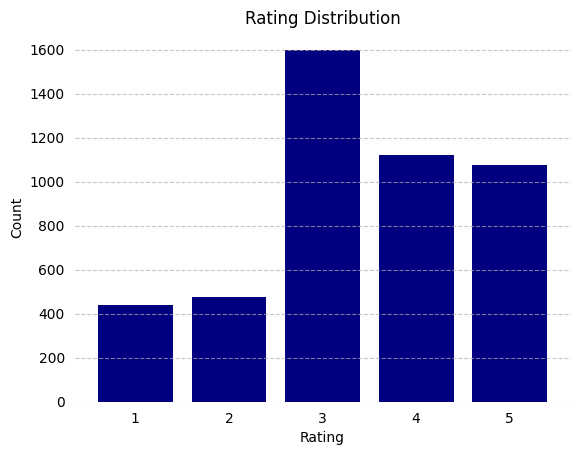

In [16]:
ax = sdf['rating'].value_counts().sort_index().plot(kind='bar', color='navy', width=0.8)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation='horizontal')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(left=False, bottom=False)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
reader = Reader(rating_scale=(1, 5))
sds = Dataset.load_from_df( # sds stands for '(s)ynthetic (d)ata(s)et'
    sdf[["uid", "iid", "rating"]], reader
    )

print(type(sds))
pd.DataFrame({'# Users': [len(set([user_id for (user_id, _, _, _) in sds.raw_ratings]))],
              '# Itens': [len(set([item_id for (_, item_id, _, _) in sds.raw_ratings]))],
              '# Ratings': [len(sds.raw_ratings)]
              }
             )

<class 'surprise.dataset.DatasetAutoFolds'>


,# Users,# Itens,# Ratings
0,100,100,4712


In [18]:
users_ids = [t[0] for t in sds.raw_ratings]
items_ids = [t[1] for t in sds.raw_ratings]

pd.DataFrame({'Min User': [np.min(users_ids)],
              'Max User': [np.max(users_ids)],
              'Min Item': [np.min(items_ids)],
              'Max Item': [np.max(items_ids)],
              }
             )

,Min User,Max User,Min Item,Max Item
0,0,99,100,199


In [19]:
"""
    Real data extraction 
"""

'\n    Real data extraction \n'

In [20]:
rds = Dataset.load_builtin('ml-100k') # rds stands for '(r)eal (d)ata(s)set'

In [21]:
pd.DataFrame({'# Users': [len(set([user_id for (user_id, _, _, _) in rds.raw_ratings]))],
              '# Itens': [len(set([item_id for (_, item_id, _, _) in rds.raw_ratings]))],
              '# Ratings': [len(rds.raw_ratings)]
              }
             )

,# Users,# Itens,# Ratings
0,943,1682,100000


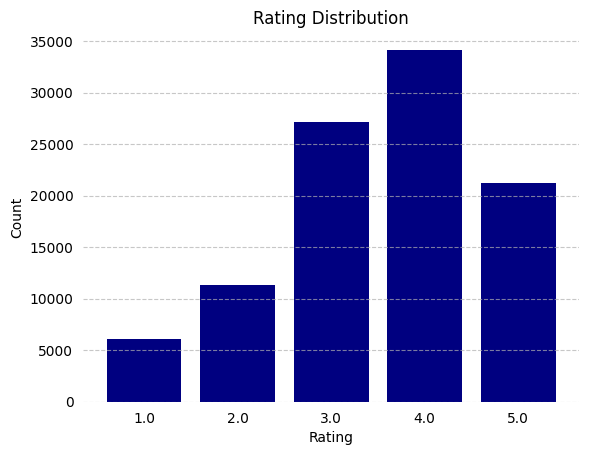

In [22]:
ax = pd.DataFrame(rds.build_full_trainset().all_ratings(), 
                  columns=['uid', 'iid', 'rating'])['rating'].value_counts().sort_index().plot(kind='bar', color='navy', width=0.8)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation='horizontal')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(left=False, bottom=False)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [23]:
users_ids = [int(t[0]) for t in rds.raw_ratings]
items_ids = [int(t[1]) for t in rds.raw_ratings]

pd.DataFrame({'Min User': [np.min(users_ids)],
              'Max User': [np.max(users_ids)],
              'Min Item': [np.min(items_ids)],
              'Max Item': [np.max(items_ids)],
              }
             )

,Min User,Max User,Min Item,Max Item
0,1,943,1,1682


### Running experiments

In [24]:
datasets = {
    'synthetic': sds,
    'real': rds
}

In [25]:
results=[]
tracking=[]

for dataname, dataset in tqdm(datasets.items(), desc='Experiment Progress', leave=True):
    for test_size in [0.25, 0.1, 0.01]:
        shuffle_split = ShuffleSplit(n_splits=5, test_size=test_size)
        split_id = 1
        for trainset, testset in shuffle_split.split(dataset):
            edges = from_ratings_to_edges(trainset.all_ratings())    
            ui_gr = nx.from_pandas_edgelist(edges, edge_attr=True)
            g = nx.bipartite.generic_weighted_projected_graph(ui_gr,
                                                              edges.source.unique(), wf
                                                              ) 
            trainpd = pd.DataFrame(trainset.all_ratings(), 
                                       columns=['inner_uid', 'inner_iid', 'rating']
                                       )
            trainpd['raw_uid'] = trainpd['inner_uid'].apply(trainset.to_raw_uid)
            trainpd['raw_iid'] = trainpd['inner_iid'].apply(trainset.to_raw_iid)
            testpd = pd.DataFrame(testset, 
                                  columns=['raw_uid', 'raw_iid', 'rating']
                                  )
            for detector_name, community_detector in communities_detectors.items():
                if community_detector == None:
                    for algo_name, algo in  algos_recommendation.items(): 
                        start_time = time.time()
                        algo.fit(trainset)
                        training_time = time.time() - start_time
                        start_time = time.time()
                        predictions = algo.test(testset)
                        testing_time = time.time() - start_time
                        rmse_value = accuracy.rmse(predictions, verbose=False)
                        mse_value = accuracy.mse(predictions, verbose=False)
                        mae_value = accuracy.mae(predictions, verbose=False)
                        result_dict = {
                                'dataset': dataname,
                                'community_detector': detector_name,
                                'algorithm_rec': algo_name,
                                'test_size': test_size,
                                'split_id': split_id,
                                'rmse': rmse_value,
                                'mse': mse_value,
                                'mae': mae_value
                        }
                        results.append(result_dict)
                        tracking_dict = {
                                'dataset': dataname,
                                'community_detector': detector_name,
                                'community': np.nan,
                                'algorithm_rec': algo_name,
                                'test_size': test_size,
                                'split_id': split_id,
                                'train_runtime': training_time,
                                'test_runtime': testing_time,    
                            }
                        tracking.append(tracking_dict)
                else:
                    coms = community_detector(g.copy())
                    if detector_name == 'Paris':
                        coms = coms.communities
                    for algo_name, algo in  algos_recommendation.items():
                        all_predictions = []
                        for idx, com in enumerate(coms):
                            train_community = trainpd[trainpd.inner_uid.isin(com)][['raw_uid', 'raw_iid', 'rating']]
                            train_community = Dataset.load_from_df(train_community, reader).build_full_trainset()           
                            c_raw = set(map(trainset.to_raw_uid, com))
                            test_community = testpd[testpd.raw_uid.isin(c_raw)] 
                            start_time = time.time()
                            algo.fit(train_community)
                            training_time = time.time() - start_time
                            start_time = time.time()
                            predictions = algo.test(test_community.values)
                            testing_time = time.time() - start_time
                            all_predictions.extend(predictions)
                            tracking_dict = {
                                'dataset': dataname,
                                'community_detector': detector_name,
                                'community': idx+1,
                                'algorithm_rec': algo_name,
                                'test_size': test_size,
                                'split_id': split_id,
                                'train_runtime': training_time,
                                'test_runtime': testing_time,    
                            }
                            tracking.append(tracking_dict)
                            
                        rmse_value = accuracy.rmse(all_predictions, verbose=False)
                        mse_value = accuracy.mse(all_predictions, verbose=False)
                        mae_value = accuracy.mae(all_predictions, verbose=False)
                        result_dict = {
                                'dataset': dataname,
                                'community_detector': detector_name,
                                'algorithm_rec': algo_name,
                                'test_size': test_size,
                                'split_id': split_id,
                                'rmse': rmse_value,
                                'mse': mse_value,
                                'mae': mae_value
                                }
                        results.append(result_dict) 
            split_id += 1  
            
            
notebook_dir = os.getcwd()
outputs_dir = notebook_dir.replace('notebooks', 'outputs')

resultspd = pd.DataFrame(results)
file_name = f'experiment_results.csv'
file_path = os.path.join(outputs_dir, file_name)
resultspd.to_csv(file_path, index=False)

trackingpd = pd.DataFrame(tracking)
file_name = f'experiment_runs_cost.csv'
file_path = os.path.join(outputs_dir, file_name)
trackingpd.to_csv(file_path, index=False)

Experiment Progress:   0%|          | 0/2 [00:00<?, ?it/s]